In [1]:
# Function takes a folder path as an argument. If the image is present in either EOSINOPHIL or NEUTROPHIL folder, 
# it will be labelled as Polynuclear else it will be labelled as Mononuclear. 

# Function returns two numpy arrays. 

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Lambda
from keras.layers import Dense
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2
import scipy
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def data_pre_processing(folder):

    X = []
    y = []

    for folder_name in os.listdir(folder):
        if not folder_name.startswith('.'):
            if folder_name in ['EOSINOPHIL','NEUTROPHIL']:
                label = 'POLYNUCLEAR'
            else:
                label = 'MONONUCLEAR'
            for image_filename in os.listdir(folder + folder_name):
                img_file = cv2.imread(folder + folder_name + '/' + image_filename)
                if img_file is not None:
                    img_file = scipy.misc.imresize(arr=img_file, size=(120, 160, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

Using TensorFlow backend.


###### Variable declaration

In [2]:
epochs = 17
BASE_DIR = '/Users/srivatsa.n/Documents/WorkSpace/CNN-Project/Coding/Data/wbc-classification'
batch_size = 32

###### Data collection and processing

In [4]:
X_train, y_train = data_pre_processing(BASE_DIR + '/images/TRAIN/')
X_test, y_test = data_pre_processing(BASE_DIR + '/images/TEST_SIMPLE/')

###### Data visualisation and data distribution

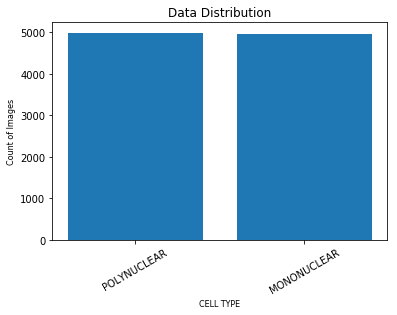

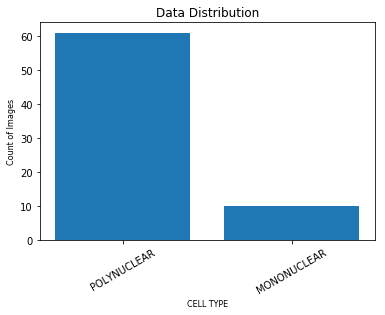

In [5]:
#Data Visualisation
import collections 

def countFrequency(arr): 
    return collections.Counter(arr)   
 

def plot_bar(x_axis,y_axis):
    index = np.arange(len(x_axis))
    plt.bar(index, y_axis)
    plt.xlabel('CELL TYPE', fontsize=8)
    plt.ylabel('Count of Images', fontsize=8)
    plt.xticks(index, x_axis, fontsize=10, rotation=30)
    plt.title('Data Distribution')
    plt.show()
    
y_train_freq = countFrequency(y_train)

x_axis = []
y_axis = []

for key, value in y_train_freq.items(): 
        x_axis.append(key)
        y_axis.append(value)
    
plot_bar(x_axis,y_axis)

y_test_freq = countFrequency(y_test)

x_axis_test = []
y_axis_test = []

for key, value in y_test_freq.items(): 
        x_axis_test.append(key)
        y_axis_test.append(value)

plot_bar(x_axis_test,y_axis_test)

In [6]:
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

###### Simple Neural Network Model 

In [9]:
# Function returns a model of simple neural network 

def simple_model():
    model = Sequential()
    model.add(Flatten(input_shape = X_train.shape[1:]))
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])
    model.summary()
    return model

In [10]:
model = simple_model()

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=10,
    shuffle=True,
    batch_size=100)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              57601000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1001      
Total params: 57,602,001
Trainable params: 57,602,001
Non-trainable params: 0
_________________________________________________________________
Train on 7965 samples, validate on 1992 samples
Epoch 1/10
7965/7965 [==============================] - 65s 8ms/step - loss: 6.0848 - acc: 1.2555e-04 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 2/10
7965/7965 [==============================] - 64s 8ms/step -

###### CNN Modelling and Traning 

In [93]:
# Function returns a CNN model 

def get_model():
    model = Sequential()
    model.add(Lambda(lambda x: x * 1./255., input_shape=(120, 160, 3), output_shape=(120, 160, 3)))
    model.add(Conv2D(32, (3, 3), input_shape=(120, 160, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.2))
    
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])

    return model

In [94]:
model = get_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 120, 160, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 118, 158, 32)      896       
_________________________________________________________________
activation_26 (Activation)   (None, 118, 158, 32)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 59, 79, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 59, 79, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 57, 77, 32)        9248      
_________________________________________________________________
activation_27 (Activation)   (None, 57, 77, 32)        0         
__________

In [95]:
model = get_model()

# fits the model on batches
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=epochs,
    shuffle=True,
    batch_size=batch_size)

model.save_weights('/Users/srivatsa.n/Documents/WorkSpace/CNN-Project/Coding/Wieghts/binary_model.h5')

Train on 7965 samples, validate on 1992 samples
Epoch 1/17
7965/7965 [==============================] - 133s 17ms/step - loss: 6.0637 - acc: 0.6218 - val_loss: 14.8503 - val_acc: 0.0000e+00
Epoch 2/17
7965/7965 [==============================] - 133s 17ms/step - loss: 6.0789 - acc: 0.6228 - val_loss: 14.8503 - val_acc: 0.0000e+00
Epoch 3/17
7965/7965 [==============================] - 128s 16ms/step - loss: 6.0789 - acc: 0.6228 - val_loss: 14.8503 - val_acc: 0.0000e+00
Epoch 4/17
7965/7965 [==============================] - 128s 16ms/step - loss: 1.7020 - acc: 0.6215 - val_loss: 0.7941 - val_acc: 0.0000e+00
Epoch 5/17
7965/7965 [==============================] - 127s 16ms/step - loss: 0.6334 - acc: 0.6318 - val_loss: 0.7599 - val_acc: 0.5131
Epoch 6/17
7965/7965 [==============================] - 124s 16ms/step - loss: 0.5441 - acc: 0.7071 - val_loss: 1.0009 - val_acc: 0.3012
Epoch 7/17
7965/7965 [==============================] - 124s 16ms/step - loss: 0.4672 - acc: 0.7586 - val_loss:

###### Model Evaluation

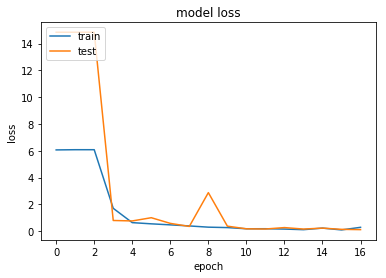

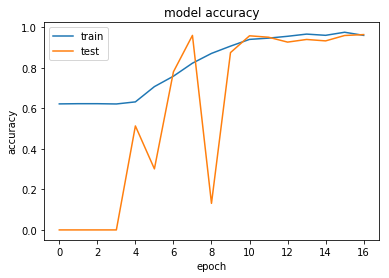

In [96]:
# Function is used to draw accuracy vs Epochs curve

def accuracy_curve(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.show()

# Function is used to draw loss vs Epochs curve

def loss_curve(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')
    plt.show()
    
loss_curve(history)
accuracy_curve(history)

In [97]:
from sklearn.metrics import accuracy_score

print('Predicting on test data')
y_pred = np.rint(model.predict(X_test))
print(accuracy_score(y_test, y_pred))

Predicting on test data
0.9577464788732394


In [98]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

[[ 9  1]
 [ 2 59]]


In [99]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
  
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

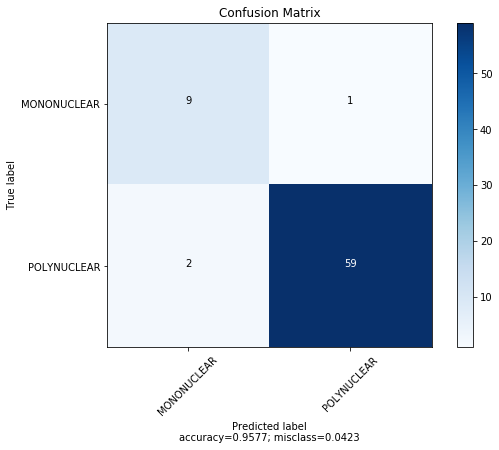

In [100]:
plot_confusion_matrix(cm= confusion_matrix(y_test, y_pred),normalize= False,target_names = ['MONONUCLEAR', 'POLYNUCLEAR'],title= "Confusion Matrix")

###### Prediction

In [32]:
# Function takes image path as an argument. Resizes the image. Returns the image as numpy parameter. 
def prepare(imagepath):
    
    X=[]
    
    img_file = cv2.imread(imagepath)
    if img_file is not None:
                    # Downsample the image to 120, 160, 3
                    img_file = scipy.misc.imresize(arr=img_file, size=(120, 160, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
    X = np.asarray(X)
    return X
    

In [33]:
# Function takes image path as an argument.
# Invokes prepare function
# Outputs the preddiction and prints the WBC image. 
def predictTheCell(imagepath):
    CELLTYPE = ["MONONUCLEAR","POLYNUCLEAR"]
    prediction = model.predict(prepare(imagepath))
    print ('The WBC is a ' + CELLTYPE[int(np.rint(prediction[0][0]))])
    img = cv2.imread(imagepath)
    img2 = img[:,:,::-1]
    plt.imshow(img2)

The WBC is a MONONUCLEAR


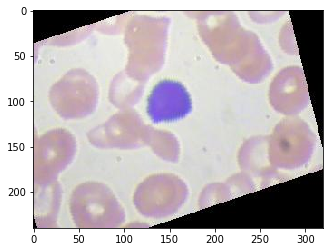

In [34]:
predictTheCell('PredictMonoNuclear.jpeg')

The WBC is a POLYNUCLEAR


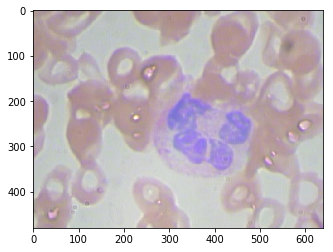

In [13]:
predictTheCell('PolyNuclear_1.jpeg')

The WBC is a POLYNUCLEAR


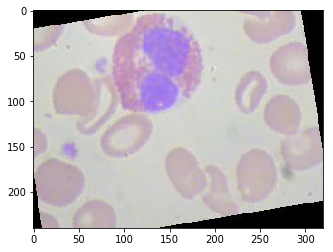

In [14]:
predictTheCell('PredictMonoNuclear_2.jpeg')